In [ ]:
%%capture
!pip install transformers
!pip install datasets
!pip install transformers[torch]
!pip install accelerate
!pip install huggingface_hub

### Load dataset

In [ ]:
import re
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.functional import cross_entropy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# Hugging Face
from huggingface_hub import HfApi
from huggingface_hub import notebook_login
from datasets import Dataset
from datasets import load_dataset
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AutoModelForSequenceClassification

# Load dataset and remove empty values
dataset = load_dataset("solomonk/reddit_mental_health_posts")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/solomonk___csv/solomonk--reddit_mental_health_posts-ebd98f1303b315a0/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['author', 'body', 'created_utc', 'id', 'num_comments', 'score', 'subreddit', 'title', 'upvote_ratio', 'url'],
        num_rows: 151288
    })
})

### Clean dataset

In [ ]:
def prepare_data(df):
  # Concatenate title and body
  df['body'] = df.body.fillna('')
  df['body'] = df.body.str.cat(df.title, sep=' ')

  # Removed deleted posts
  df = df[~df.author.str.contains('\[deleted\]')]
  df = df[~df.body.str.contains('\[removed\]')]
  df = df[~df.body.str.contains('\[deleted\]')]
  df = df[~df.body.str.contains('\[deleted by user\]')]

  # Removed moderador posts
  df = df[df.author!='AutoModerator']

  return df[['body', 'subreddit']]

def remove_mental_health_references(df):
  unique_labels = df.subreddit.unique()
  pattern = '|'.join(unique_labels)
  df.body = df.body.str.replace(pattern, '', regex=True)
  return df

In [ ]:
df = dataset["train"].to_pandas()
df = prepare_data(df).reset_index(drop=True)
df = remove_mental_health_references(df).reset_index(drop=True)
dataset = Dataset.from_pandas(df)

In [ ]:
dataset

Dataset({
    features: ['body', 'subreddit'],
    num_rows: 84764
})

### Split train and test

In [ ]:
dataset_sampled = dataset.train_test_split(test_size=0.7, seed=42)['train']

train_val_test = dataset_sampled.train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_test['train']
test_val_dataset = train_val_test['test']

test_val_split = test_val_dataset.train_test_split(test_size=0.5, seed=42)
validation_dataset = test_val_split['train']
test_dataset = test_val_split['test']

columns_to_keep = ['body', 'subreddit']
columns_to_remove = [col for col in dataset_sampled.column_names if col not in columns_to_keep]

train_dataset = train_dataset.remove_columns(columns_to_remove)
validation_dataset = validation_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.remove_columns(columns_to_remove)

### Encode labels

In [ ]:
le = LabelEncoder()
le.fit(dataset_sampled['subreddit'])

def encode_labels(example):
    example['subreddit'] = le.transform([example['subreddit']])[0]
    return example

train_dataset = train_dataset.map(encode_labels)
validation_dataset = validation_dataset.map(encode_labels)
test_dataset = test_dataset.map(encode_labels)

Map:   0%|          | 0/20343 [00:00<?, ? examples/s]

Map:   0%|          | 0/2543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2543 [00:00<?, ? examples/s]

### Tokenize text

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def prepare_data(example):
    encoding = tokenizer.encode_plus(
        example['body'],
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt',
    )
    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(example['subreddit'], dtype=torch.long)
    }

train_dataset = train_dataset.map(prepare_data)
validation_dataset = validation_dataset.map(prepare_data)
test_dataset = test_dataset.map(prepare_data)

Map:   0%|          | 0/20343 [00:00<?, ? examples/s]

Map:   0%|          | 0/2543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2543 [00:00<?, ? examples/s]

### Train model

In [ ]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(le.classes_))

training_args = TrainingArguments(
    output_dir='./output',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

trainer.train()
trainer.evaluate(test_dataset)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.814500
1000,0.454700
1500,0.385600
2000,0.296400
2500,0.268500


{'eval_loss': 0.32857421040534973,
 'eval_runtime': 76.6509,
 'eval_samples_per_second': 33.176,
 'eval_steps_per_second': 2.074,
 'epoch': 2.0}

Lasted: 1h 56m 52s

Lasted: 1h 52m 18s

Lasted: 1h 4m 28s

### Move model from results to output folder

In [ ]:
#import shutil
#shutil.move('./results', './output')

### Save model

In [ ]:
trainer.save_model()

### Push to Hugging Face Hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#trainer.push_to_hub(repo_name="fzetter/roberta-mental-health")

model.push_to_hub("fzetter/roberta-mental-health")
tokenizer.push_to_hub("fzetter/roberta-mental-health")

#api = HfApi()
#api.upload_folder(folder_path="./results", repo_id="fzetter/roberta-mental-health")

CommitInfo(commit_url='https://huggingface.co/fzetter/roberta-mental-health/commit/b6524259af15f6321dc89d4b1877cab44dd4b03c', commit_message='Upload tokenizer', commit_description='', oid='b6524259af15f6321dc89d4b1877cab44dd4b03c', pr_url=None, pr_revision=None, pr_num=None)

### Retrieve model from Hugging Face Hub

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('fzetter/roberta-mental-health')

In [ ]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

training_args = TrainingArguments(
    output_dir='./output',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

### Get predictions

In [ ]:
prediction_output = trainer.predict(test_dataset)
predictions = np.argmax(prediction_output.predictions, axis=-1)
print(f'Metrics: { prediction_output.metrics }')

Metrics: {'test_loss': 0.32857421040534973, 'test_runtime': 72.1014, 'test_samples_per_second': 35.27, 'test_steps_per_second': 2.205}


In [ ]:
# Get labels
labels = prediction_output.label_ids

# Get loss
torch_tensor = torch.from_numpy(prediction_output.predictions)
labels_torch = torch.tensor(labels)
loss = cross_entropy(torch_tensor,labels_torch, reduction="none")

df = pd.DataFrame({'predictions': predictions, 'ground_truth': labels, "losses": loss })

In [ ]:
df

,predictions,ground_truth,losses
0,3,3,0.304251
1,0,0,0.004775
2,2,3,1.220814
3,0,2,2.069568
4,0,0,0.001821
...,...,...,...
2538,1,1,0.001298
2539,1,1,0.506800
2540,1,1,0.001243
2541,1,1,0.001565


In [ ]:
df.predictions = le.inverse_transform(df.predictions)
df.ground_truth = le.inverse_transform(df.ground_truth)

df["text"] = test_dataset["body"]
df["len"] = df.text.str.len()

In [ ]:
df

,predictions,ground_truth,losses,text,len
0,depression,depression,0.304251,Last week I was involved in a nasty car accide...,1748
1,ADHD,ADHD,0.004775,So my Vyvanse was upped from 20 to 30 mg. It’s...,461
2,aspergers,depression,1.220814,\nI had to delete the paragraphs that I wrote ...,119
3,ADHD,aspergers,2.069568,"Now when I do something “BIG”, I’m done for th...",383
4,ADHD,ADHD,0.001821,I was on generic ritalin 10mg 2-3x daily and w...,589
...,...,...,...,...,...
2538,OCD,OCD,0.001298,I had an intrusive thought about a sexualized ...,375
2539,OCD,OCD,0.506800,It's strange because it's not even like it's a...,552
2540,OCD,OCD,0.001243,What if I don't do the things my OCD tells me ...,228
2541,OCD,OCD,0.001565,I recently went to the Dr. and had a test done...,1986


### Classfication report

In [ ]:
report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report: ")
print(report)

Classification Report: 
              precision    recall  f1-score   support

        ADHD       0.93      0.92      0.92       600
         OCD       0.96      0.93      0.94       720
   aspergers       0.84      0.83      0.84       410
  depression       0.83      0.87      0.85       440
        ptsd       0.87      0.89      0.88       373

    accuracy                           0.89      2543
   macro avg       0.88      0.89      0.89      2543
weighted avg       0.90      0.89      0.90      2543



### ROC Curve using One-vs-Rest (OvR)

 Treat each class as the positive class and the rest as negative, then calculate ROC and AUC for each class separately.

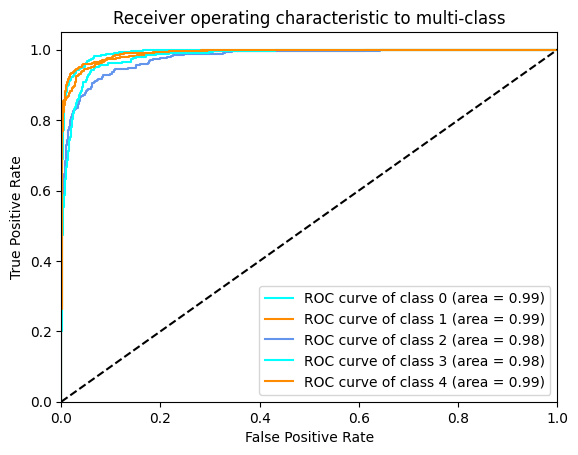

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
from scipy.special import softmax

# Binarize the output labels
true_labels_bin = label_binarize(labels, classes=np.unique(labels))

# Get prediction probabilities
prediction_probs = softmax(prediction_output.predictions, axis=-1)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(labels))):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], prediction_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(len(np.unique(labels))), colors):
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### Compare losses
(TBA)

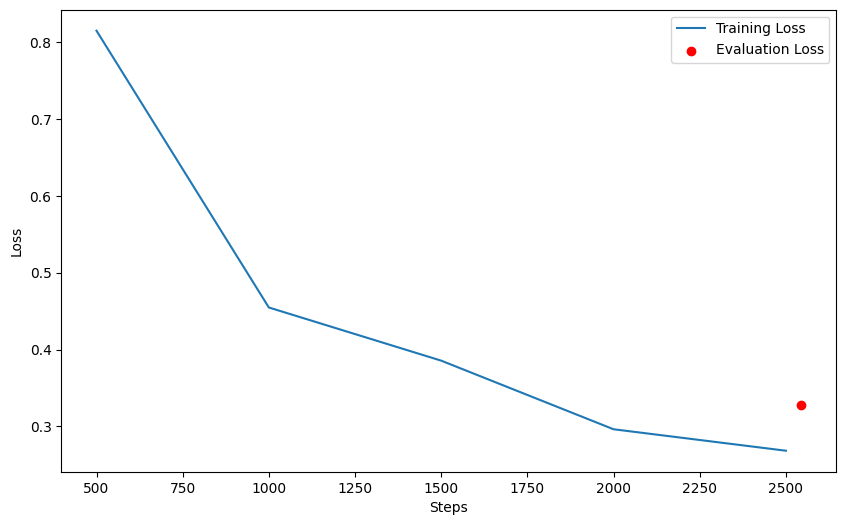

In [ ]:
# Assume trainer.state.log_history contains your training logs
logs = trainer.state.log_history

# Extract training losses and evaluation losses to lists
training_losses = [x['loss'] for x in logs if 'loss' in x]
evaluation_losses = [x['eval_loss'] for x in logs if 'eval_loss' in x]

# Generate corresponding step numbers for training loss
training_steps = [x['step'] for x in logs if 'loss' in x]

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(training_steps, training_losses, label='Training Loss')
plt.scatter([x['step'] for x in logs if 'eval_loss' in x], evaluation_losses, color='red', label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Confusion matrix

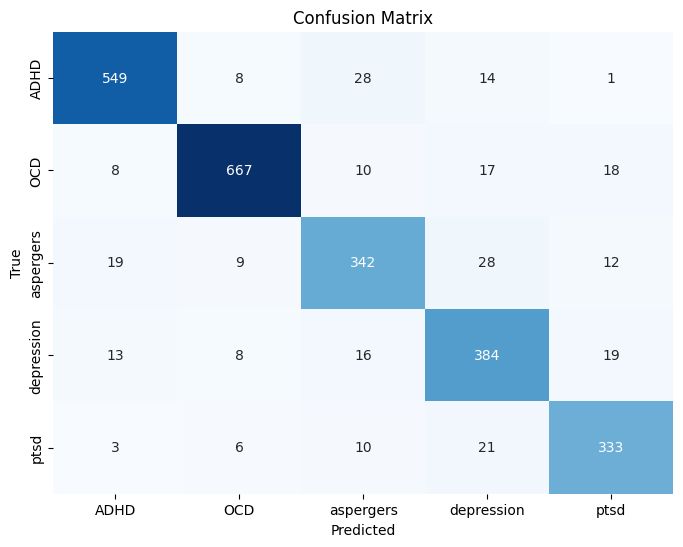

In [ ]:
confusion = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Lower and higher losses

In [ ]:
df.sort_values("losses").head(10)

,predictions,ground_truth,losses,text,len
2138,OCD,OCD,0.001219,"My ocd is terrible, has been my whole life. I ...",338
2516,OCD,OCD,0.001222,I read hundreds of stories about ocd and can n...,298
1929,OCD,OCD,0.001223,I used to suffer from pocd and intrusive thoug...,413
2293,OCD,OCD,0.001224,I conquered just about every ocd aspect i have...,807
1291,OCD,OCD,0.001225,"\nhi! im 14F and right now, im really scared a...",1548
123,OCD,OCD,0.001226,Basically if I have a thought and I don't like...,221
198,OCD,OCD,0.001226,So today I was able to confess stuff that’s be...,327
1857,OCD,OCD,0.001227,"I have had OCD all my life, but i haven't been...",1146
1894,OCD,OCD,0.001227,Had pure ocd since i could remember so really ...,1029
2533,OCD,OCD,0.001227,Hey I'm a 27 years old female\n\n I alwa...,3167


In [ ]:
df.sort_values("losses").tail(10)

,predictions,ground_truth,losses,text,len
941,ptsd,depression,5.684953,How do you overcome feelings of hopelessness....,869
110,depression,ADHD,6.130956,Look its even hard to type. I dont feel like d...,1588
1773,aspergers,depression,6.200171,Hello. I'm 21 years old and have been having p...,1800
1304,OCD,depression,6.242258,I have a month off from school for Christmas b...,139
682,ADHD,depression,6.466464,I have this weird phenomenon that whenever I e...,1893
2166,aspergers,OCD,6.676702,The desk was like $300 and assembly was $125. ...,1319
1975,aspergers,depression,6.716852,"Long story short, I believe I have autism. The...",1424
47,ADHD,OCD,6.851979,"Im 16 years old, male, 5’6, about 130 pounds, ...",2433
762,OCD,aspergers,7.012166,🚂🚂🚂🚂🚈🚈🚈🚈🚈🚈🚆🚆🚆🚆🚆🚄🚄🚄🚅🚅🚋🚋🚋 TRAIN APPRECIATION THR...,55
1652,ptsd,aspergers,7.220975,Just want to share some support for those who ...,686


### Metrics

In [ ]:
df.groupby("ground_truth"	).describe()

losses                                                    \
              count      mean       std       min       25%       50%   
ground_truth                                                            
ADHD          600.0  0.237188  0.790016  0.001477  0.001649  0.002437   
OCD           720.0  0.241745  0.864896  0.001219  0.001367  0.002020   
aspergers     410.0  0.520680  1.217387  0.002734  0.003529  0.009651   
depression    440.0  0.448826  1.129157  0.011853  0.020206  0.033222   
ptsd          373.0  0.290169  0.841707  0.002884  0.003415  0.004938   

                                    len                                   \
                   75%       max  count         mean          std    min   
ground_truth                                                               
ADHD          0.022753  6.130956  600.0  1059.611667   795.618339  325.0   
OCD           0.005082  6.851979  720.0   863.627778  1009.703392   13.0   
aspergers     0.169436  7.220975  410.0   954.690244  1279.585226   31.0   
depression    0.185332  6.716852  440.0   933.147727   989.627566   25.0   
ptsd          0.019677  5.094659  373.0  1136.276139  1084.479280   44.0   

                                               
                 25%    50%      75%      max  
ground_truth                                   
ADHD          566.75  817.0  1278.00   5966.0  
OCD           313.50  562.0  1054.00  13446.0  
aspergers     329.75  628.5  1097.50  17780.0  
depression    292.00  657.0  1272.25   7450.0  
ptsd          445.00  825.0  1486.00   7893.0

In [ ]:
df.groupby("predictions").describe()

losses                                                    \
             count      mean       std       min       25%       50%   
predictions                                                            
ADHD         592.0  0.244384  0.896220  0.001477  0.001648  0.002404   
OCD          698.0  0.159947  0.708429  0.001219  0.001363  0.001984   
aspergers    406.0  0.439774  1.079141  0.002734  0.003511  0.009017   
depression   464.0  0.546032  1.135134  0.011853  0.021053  0.037314   
ptsd         383.0  0.384697  1.059314  0.002884  0.003427  0.005083   

                                   len                                  \
                  75%       max  count         mean          std   min   
predictions                                                              
ADHD         0.019309  6.851979  592.0  1071.744932   828.386905  81.0   
OCD          0.004518  7.012166  698.0   861.091691  1013.144690  13.0   
aspergers    0.164055  6.716852  406.0   968.251232  1233.709657  31.0   
depression   0.300837  6.130956  464.0   899.392241   907.215866  25.0   
ptsd         0.022379  7.220975  383.0  1142.232376  1174.225366  44.0   

                                              
                25%    50%      75%      max  
predictions                                   
ADHD         566.00  821.5  1284.50   5966.0  
OCD          306.25  563.0  1053.00  13446.0  
aspergers    341.25  660.5  1174.25  17780.0  
depression   295.50  642.0  1256.00   7450.0  
ptsd         416.00  782.0  1465.00   7893.0

<Axes: xlabel='predictions', ylabel='losses'>

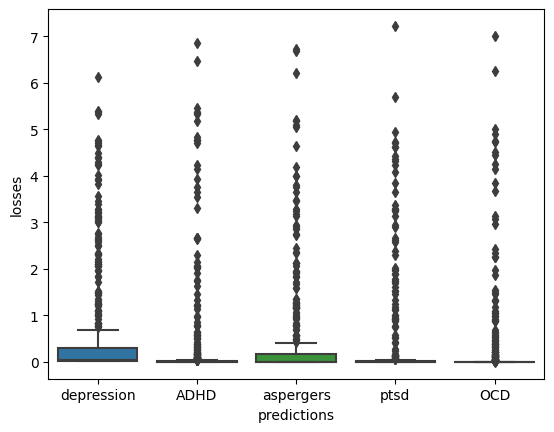

In [ ]:
sns.boxplot(data = df, y = "losses", x = "predictions")

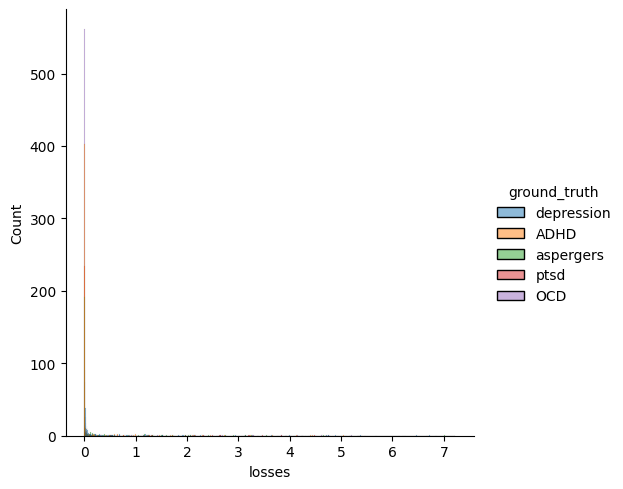

In [ ]:
sns.displot(df, x="losses", hue="ground_truth")

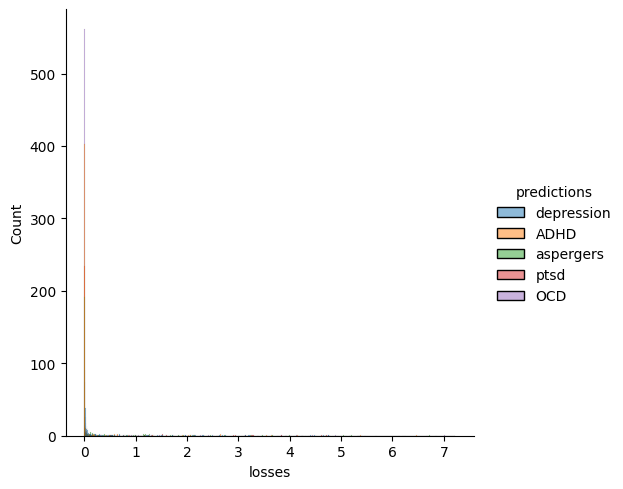

In [ ]:
sns.displot(df, x="losses", hue="predictions")

In [ ]:
bad_predictions = df[df.predictions != df.ground_truth]
bad_predictions.describe()

,losses,len
count,268.000000,268.000000
mean,2.730765,898.992537
std,1.509532,1037.135211
min,0.711451,35.000000
25%,1.452134,324.000000
50%,2.332844,590.000000
75%,3.835948,1041.500000
max,7.220975,7258.000000


<Axes: ylabel='Density'>

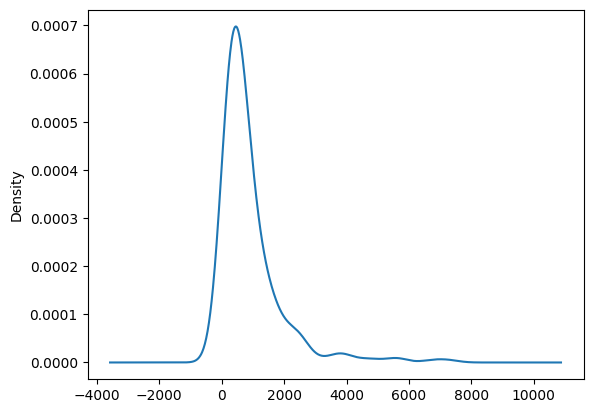

In [ ]:
bad_predictions.len.plot(kind="kde")